In [1]:
import os
import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D,PReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import  confusion_matrix,precision_score,accuracy_score,recall_score,ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import pandas as pd

In [2]:
URL="./Videos"


In [3]:
metricas={"precision":[],"recall":[]}

## Funciones definidas

In [4]:
def obtenerDatos(archivo):
   data=h5py.File(archivo)
   return data["X"][:],data["Y"][:] 

In [5]:
def obtener_etiquetas(url):
    labels=[]
    for index,carpeta in enumerate(os.listdir(str(url))):
        labels.append(carpeta)
    return labels

In [6]:
def normalizar(X):
    return X/255.0


In [7]:
def redimensionarData(X,ancho,largo,num_canales):
    imagenes=[]
    for imagen in X:
        img=imagen
        img=cv2.resize(img, (ancho, largo), interpolation=cv2.INTER_AREA)
        if(num_canales==1):
            img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1) 

        imagenes.append(img)
    return np.array(imagenes)


In [8]:
def plot_image(image):
    plt.imshow(image, cmap = "gray", interpolation = "nearest")
    plt.axis("off")

## Cargamos los datos

In [9]:
X_train,y_train=obtenerDatos("./data/datos_train_color.h5")


In [13]:
X_test,y_test=obtenerDatos("./data/datos_test_color.h5")


In [14]:
X_train.shape

(2400, 200, 200, 3)

In [15]:
y_train.shape

(2400,)

In [16]:
X_test.shape

(800, 200, 200, 3)

In [17]:
y_test.shape

(800,)

## Visualizamos la data

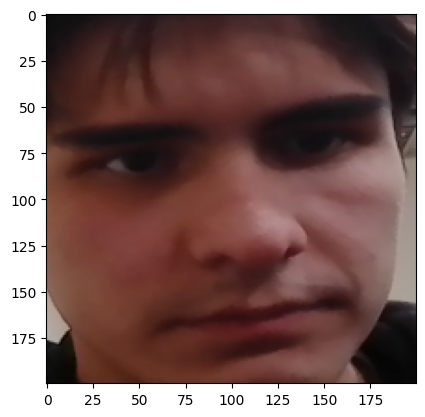

In [18]:
plt.imshow(X_train[1202])

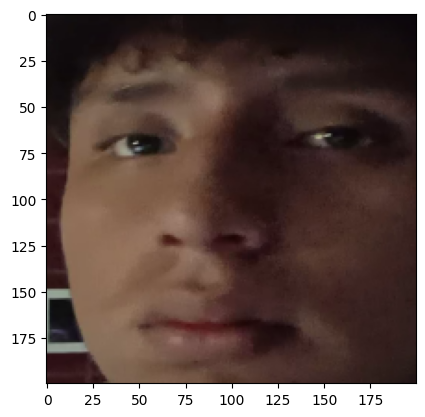

In [19]:
plt.imshow(X_train[500])

In [20]:
labels=[]

In [21]:
labels=['Agus', 'Ale', 'Noni', 'Sebas']

In [22]:
labels

['Agus', 'Ale', 'Noni', 'Sebas']

## Modelo Generico

In [23]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

In [24]:
class ModeloPersonalizado:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.modelo = None
        self.historial = None
        self.predicciones = None
        self.matriz_confusion = None

    def construir_modelo(self, configuracion):
        self.modelo = Sequential()
        self.modelo.add(InputLayer(input_shape=self.input_dim))

        # agregamos las capas convolucionales
        for capa in configuracion["capas_convolucionales"]:
            if capa["activation"]=="prelu":
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"]))
                self.modelo.add(PReLU())
            else:
                self.modelo.add(Conv2D(filters=capa["neuronas"], kernel_size=capa["kernel_size"], activation=capa["activation"]))
            if "max_pooling" in capa:
                self.modelo.add(MaxPooling2D(pool_size=capa["max_pooling"]))
            elif  "avg_pooling" in capa:
                self.modelo.add(AveragePooling2D(pool_size=capa["avg_pooling"]))

        self.modelo.add(Flatten())

        # agregamos capas densas
        for capa in configuracion["capas_ocultas"]:
            if capa["activation"]=="prelu":
                    self.modelo.add(tf.keras.layers.Dense(capa["neuronas"]))
                    self.modelo.add(tf.keras.layers.PReLU())
            else:
                self.modelo.add(Dense(capa["neuronas"], activation=capa["activation"]))
            if "dropout" in capa and capa["dropout"] > 0:
                self.modelo.add(Dropout(capa["dropout"]))

        self.modelo.add(Dense(self.output_dim, activation="softmax"))

    def compilar_modelo(self, learning_rate):
        optimizer = Nadam(learning_rate=learning_rate)
        self.modelo.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    def entrenar_modelo(self, X_train, y_train, X_val, y_val, epochs, factor_reduccion, paciencia):
        """
        Un callback en Keras es un conjunto de funciones que puedes usar para personalizar y controlar el proceso de entrenamiento del modelo
        ReduceLROnPlateau es un callback en Keras que se utiliza para reducir la tasa de aprendizaje (learning rate)
        automáticamente si una métrica(val_loss) no mejora después de un número definido de épocas (patience).
        min_lr:El learning rate no se reducirá por debajo de este valor, lo que previene que se acerque a cero.
        lr_scheduler=planificador de la tasa de aprendizaje

        Todo este trabajo se hace poruqe la tasa de aprendizaje se encarga de enontrar el j mas pequeno para los thetas
        si este j o en nuestro caso el val_loss ya no baja mucho o de la nada se subio su valor que posiblemente estemos cerca al mejor
        j o val_loss posible para los tethas y nos conviende dar pasitos mas cortos en la tasa de aprendizaje cuidando de que no sea cero con 
        min_lr
        """
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss",
            factor=factor_reduccion,
            patience=paciencia,
            verbose=1,
            min_lr=1e-6
        )

        self.historial = self.modelo.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            validation_data=(X_val, y_val), 
            callbacks=[lr_scheduler], 
            verbose=1
        )

    def evaluar_modelo(self, X_test, y_test, labels, configuracion):
        probabilidades = self.modelo.predict(X_test)
        self.predicciones = np.argmax(probabilidades, axis=1)

        #El macro average calcula la precisión y el recall de forma independiente para cada clase. Luego toma el promedio aritmético de esas métricas.
        precision = precision_score(y_test, self.predicciones, average="macro")
        recall = recall_score(y_test, self.predicciones, average="macro")

        self.matriz_confusion = confusion_matrix(y_test, self.predicciones)

        resultados = {
            "configuracion": configuracion,
            "precision": precision,
            "recall": recall,
            "historial": self.historial.history,
            "matriz_confusion": self.matriz_confusion
        }

        return resultados

## Configramos los modelos

In [25]:
configuraciones=[ 
### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"tanh",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "tanh"}
            ,{"neuronas": 84, "activation": "tanh"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "tanh"}
            ,{"neuronas": 84, "activation": "tanh"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },

    ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"relu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "relu"}
            ,{"neuronas": 84, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "relu"}
            ,{"neuronas": 84, "activation": "relu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
     ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"prelu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "prelu"}
            ,{"neuronas": 84, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "prelu"}
            ,{"neuronas": 84, "activation": "prelu"}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
#######
### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"tanh",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "tanh","dropout":0.2}
            ,{"neuronas": 84, "activation": "tanh","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"tanh",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "tanh","dropout":0.2}
            ,{"neuronas": 84, "activation": "tanh","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },

    ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"relu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "relu","dropout":0.2}
            ,{"neuronas": 84, "activation": "relu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"relu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "relu","dropout":0.2}
            ,{"neuronas": 84, "activation": "relu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
     ### LENET 5 - AVG POOLING

    {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "avg_pooling":(2,2)
           },
            {"neuronas":120,
           "kernel_size":(5, 5),
           "activation":"prelu",
           }
        ],
        "capas_ocultas": [
             {"neuronas": 120, "activation": "prelu","dropout":0.2}
            ,{"neuronas": 84, "activation": "prelu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    },
    # LENET-5 MAX POOLING
     {
       
        "input_dims":  (32,32,1),
        "capas_convolucionales":[
          {"neuronas":6,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           },
            {"neuronas":16,
           "kernel_size":(5, 5),
           "activation":"prelu",
           "max_pooling":(2,2)
           }
        ],
        "capas_ocultas": [
            {"neuronas": 120, "activation": "prelu","dropout":0.2}
            ,{"neuronas": 84, "activation": "prelu","dropout":0.2}],
        "learning_rate": 0.001,
        "factor_reduccion": 0.1,
        "output": {"neuronas": 4, "activation": "softmax"}
    }





]

In [26]:

resultados_metricas = []

for idx, config in enumerate(configuraciones):
    print(f"Entrenando modelo {idx + 1}/{len(configuraciones)}...")
    input_dims=config["input_dims"]
    X_train_copia=X_train.copy()
    X_test_copia=X_test.copy()
    X_train_copia=redimensionarData(X_train_copia,*input_dims)
    X_test_copia=redimensionarData(X_test_copia,*input_dims)
    X_train_copia=normalizar(X_train_copia)
    X_test_copia=normalizar(X_test_copia)
    print(X_train_copia.shape)
    print(X_test_copia.shape)
    

    modelo = ModeloPersonalizado(input_dim=input_dims, output_dim=4)
    modelo.construir_modelo(config)
    modelo.compilar_modelo(learning_rate=config["learning_rate"])
    modelo.entrenar_modelo(
        X_train=X_train_copia,
        y_train=y_train,
        X_val=X_test_copia,
        y_val=y_test,
        epochs=30,
        factor_reduccion=config["factor_reduccion"],
        paciencia=5,
    )
    
    resultados = modelo.evaluar_modelo(
        X_test=X_test_copia,
        y_test=y_test,
        labels=labels,
        configuracion=config
    )
    resultados_metricas.append(resultados)

    print(f"Modelo {idx + 1} se acabo de entrenar y se guardo")

df_resultados = pd.DataFrame(resultados_metricas)


Entrenando modelo 1/12...
(2400, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6249 - loss: 0.8441 - val_accuracy: 0.4613 - val_loss: 4.0160 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9975 - loss: 0.0204 - val_accuracy: 0.4712 - val_loss: 3.5791 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9978 - loss: 0.0101 - val_accuracy: 0.4613 - val_loss: 4.2578 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 0.4913 - val_loss: 3.8615 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.4650 - val_loss: 3.9631 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 6.0739e-04 - val_accuracy: 0.4600 - val_loss: 4.2074 - learning_rate: 0.0010
Epoch 7/30
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 4.8325e-04
E

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6925 - loss: 0.8311 - val_accuracy: 0.4650 - val_loss: 3.0344 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9942 - loss: 0.0292 - val_accuracy: 0.4825 - val_loss: 3.0100 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0168 - val_accuracy: 0.4762 - val_loss: 2.9384 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.4913 - val_loss: 2.6687 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.4913 - val_loss: 3.2743 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 9.0812e-04 - val_accuracy: 0.4925 - val_loss: 3.2978 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 9.7684e-04 -

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4341 - loss: 1.1053 - val_accuracy: 0.4112 - val_loss: 4.4091 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9649 - loss: 0.1306 - val_accuracy: 0.4888 - val_loss: 4.3780 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9960 - loss: 0.0292 - val_accuracy: 0.6300 - val_loss: 3.8743 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9970 - loss: 0.0211 - val_accuracy: 0.5675 - val_loss: 3.2177 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9983 - loss: 0.0093 - val_accuracy: 0.5825 - val_loss: 3.3439 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9982 - loss: 0.0103 - val_accuracy: 0.6300 - val_loss: 2.9754 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9984 - loss: 0.0067 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4981 - loss: 1.0854 - val_accuracy: 0.4638 - val_loss: 3.3625 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.1081 - val_accuracy: 0.4625 - val_loss: 4.0294 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9938 - loss: 0.0389 - val_accuracy: 0.4588 - val_loss: 3.5272 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9928 - loss: 0.0244 - val_accuracy: 0.5263 - val_loss: 4.6257 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0236 - val_accuracy: 0.5462 - val_loss: 3.9586 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9982 - loss: 0.0093 - val_accuracy: 0.4712 - val_loss: 3.1864 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9989 - loss: 0.0066 - val_accu

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4626 - loss: 1.0985 - val_accuracy: 0.4500 - val_loss: 3.5579 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9733 - loss: 0.1506 - val_accuracy: 0.6212 - val_loss: 3.7268 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9943 - loss: 0.0278 - val_accuracy: 0.6700 - val_loss: 3.1905 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9974 - loss: 0.0142 - val_accuracy: 0.6837 - val_loss: 3.6469 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9981 - loss: 0.0082 - val_accuracy: 0.6488 - val_loss: 2.5668 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9989 - loss: 0.0056 - val_accuracy: 0.7013 - val_loss: 2.9684 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9987 - loss: 0.0035 - val_ac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5289 - loss: 1.0523 - val_accuracy: 0.4575 - val_loss: 3.5175 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9881 - loss: 0.0607 - val_accuracy: 0.4575 - val_loss: 4.6135 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9955 - loss: 0.0255 - val_accuracy: 0.4613 - val_loss: 4.2976 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9811 - loss: 0.0485 - val_accuracy: 0.4925 - val_loss: 4.5178 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9967 - loss: 0.0134 - val_accuracy: 0.5562 - val_loss: 4.0655 - learning_rate: 0.0010
Epoch 6/30
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9984 - loss: 0.0043
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9984 - loss: 0.0042 - val_ac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6916 - loss: 0.7873 - val_accuracy: 0.4775 - val_loss: 3.9384 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9941 - loss: 0.0228 - val_accuracy: 0.4625 - val_loss: 3.4243 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9985 - loss: 0.0089 - val_accuracy: 0.5100 - val_loss: 3.6545 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9988 - loss: 0.0049 - val_accuracy: 0.5250 - val_loss: 4.0391 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5263 - val_loss: 3.4188 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 9.0481e-04 - val_accuracy: 0.5525 - val_loss: 3.7764 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 5.2493e-04 

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6648 - loss: 0.8509 - val_accuracy: 0.4563 - val_loss: 3.2010 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9978 - loss: 0.0180 - val_accuracy: 0.4638 - val_loss: 3.0808 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.4638 - val_loss: 3.0083 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9994 - loss: 0.0040 - val_accuracy: 0.4600 - val_loss: 3.2696 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.4625 - val_loss: 3.7539 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.4638 - val_loss: 4.2475 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9999 - loss: 0.0014 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.4792 - loss: 1.1458 - val_accuracy: 0.5600 - val_loss: 2.4280 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9430 - loss: 0.1762 - val_accuracy: 0.6200 - val_loss: 2.8982 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9898 - loss: 0.0458 - val_accuracy: 0.7138 - val_loss: 2.8251 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9988 - loss: 0.0102 - val_accuracy: 0.7025 - val_loss: 2.2781 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9932 - loss: 0.0232 - val_accuracy: 0.6175 - val_loss: 2.9423 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9967 - loss: 0.0194 - val_accuracy: 0.7088 - val_loss: 2.0786 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9959 - loss: 0.0106 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(2400, 32, 32, 1)
(800, 32, 32, 1)


C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4742 - loss: 1.1106 - val_accuracy: 0.2450 - val_loss: 2.8275 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9485 - loss: 0.1945 - val_accuracy: 0.4688 - val_loss: 3.6331 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9891 - loss: 0.0485 - val_accuracy: 0.4613 - val_loss: 3.4458 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9941 - loss: 0.0359 - val_accuracy: 0.4925 - val_loss: 3.1949 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9965 - loss: 0.0212 - val_accuracy: 0.4625 - val_loss: 3.5654 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9935 - loss: 0.0202
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9935 - loss: 0.0201 - val_acc

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4197 - loss: 1.1454 - val_accuracy: 0.4563 - val_loss: 3.4016 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9495 - loss: 0.1982 - val_accuracy: 0.5525 - val_loss: 3.2422 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9948 - loss: 0.0303 - val_accuracy: 0.4863 - val_loss: 3.3717 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9955 - loss: 0.0247 - val_accuracy: 0.5150 - val_loss: 2.9258 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9986 - loss: 0.0099 - val_accuracy: 0.4675 - val_loss: 2.6837 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.4837 - val_loss: 2.7811 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9983 - loss: 0.0071 - val_ac

C:\Users\SEBASTIAN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.4381 - loss: 1.1299 - val_accuracy: 0.2837 - val_loss: 2.0123 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9692 - loss: 0.1380 - val_accuracy: 0.3913 - val_loss: 2.8862 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9922 - loss: 0.0356 - val_accuracy: 0.5387 - val_loss: 3.0228 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9970 - loss: 0.0223 - val_accuracy: 0.5550 - val_loss: 4.2362 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9978 - loss: 0.0175 - val_accuracy: 0.5350 - val_loss: 2.8788 - learning_rate: 0.0010
Epoch 6/30
73/75 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9993 - loss: 0.0048
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9992 - loss: 0.0049 - val_ac

Modelo 1:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0
  Capa 2: 84 neuronas, activación='tanh', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5165
Recall: 0.4713

Graficando historial de entrenamiento...


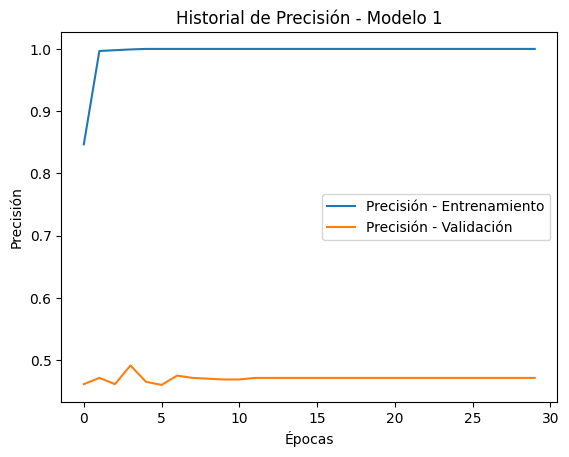

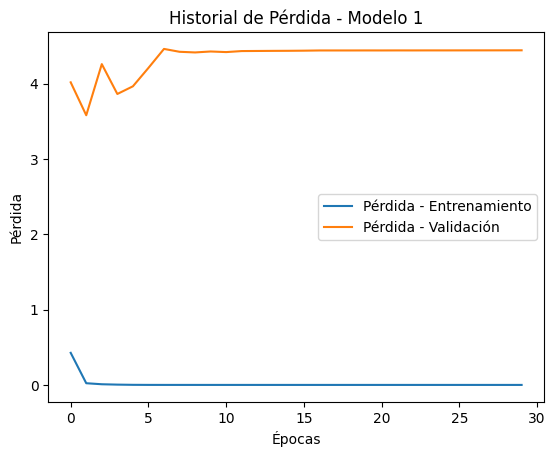


Matriz de Confusión:


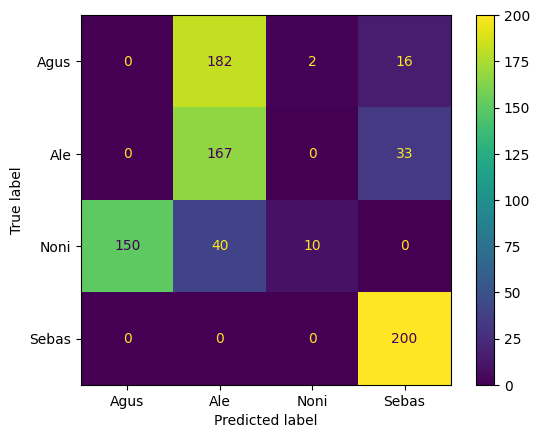



Modelo 2:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0
  Capa 2: 84 neuronas, activación='tanh', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5646
Recall: 0.4825

Graficando historial de entrenamiento...


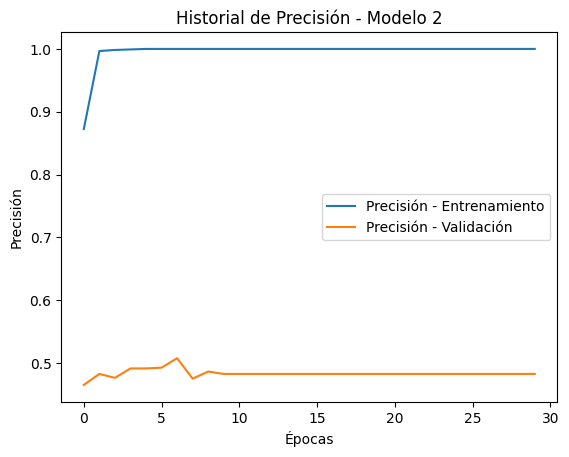

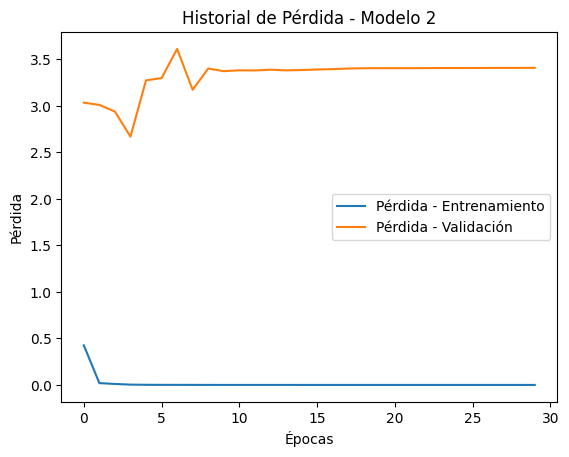


Matriz de Confusión:


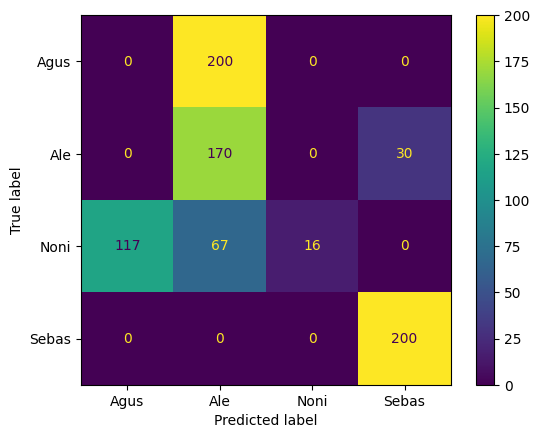



Modelo 3:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0
  Capa 2: 84 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5593
Recall: 0.6450

Graficando historial de entrenamiento...


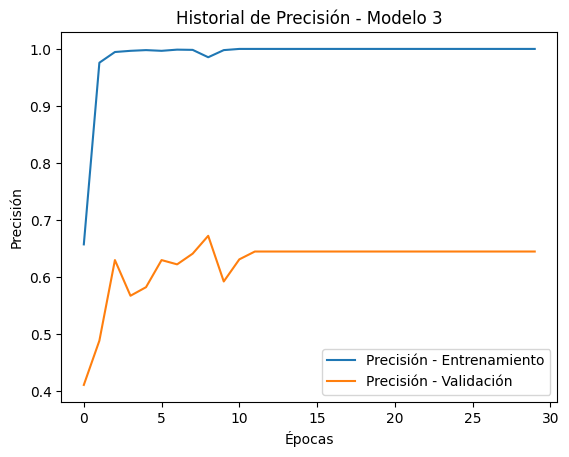

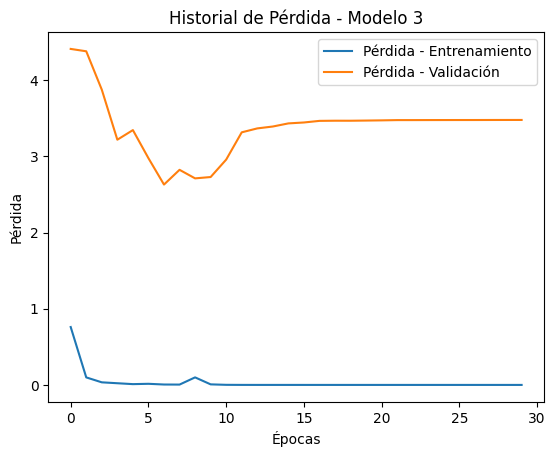


Matriz de Confusión:


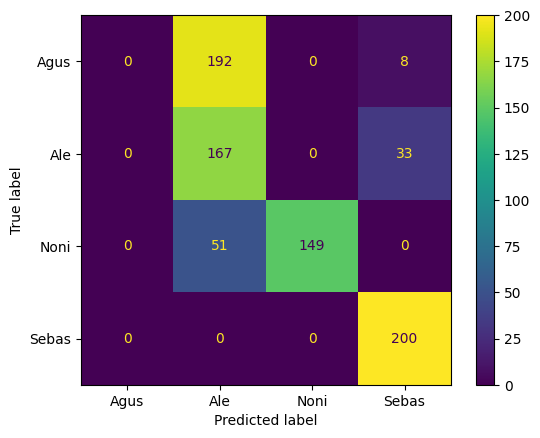



Modelo 4:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0
  Capa 2: 84 neuronas, activación='relu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5586
Recall: 0.5300

Graficando historial de entrenamiento...


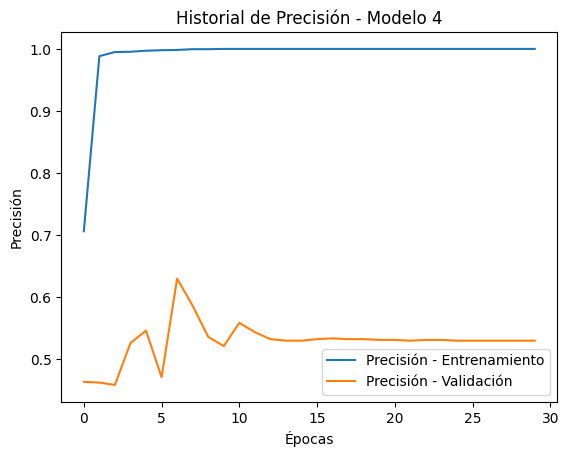

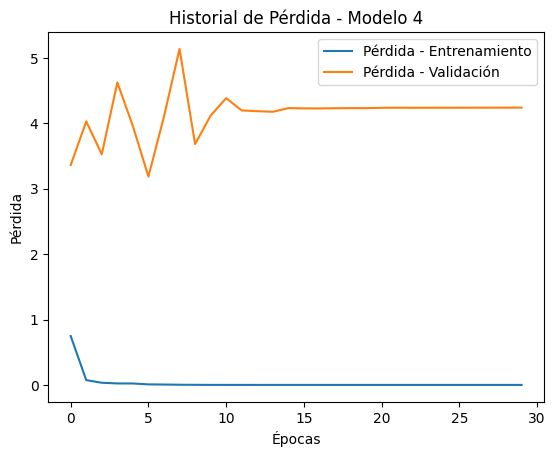


Matriz de Confusión:


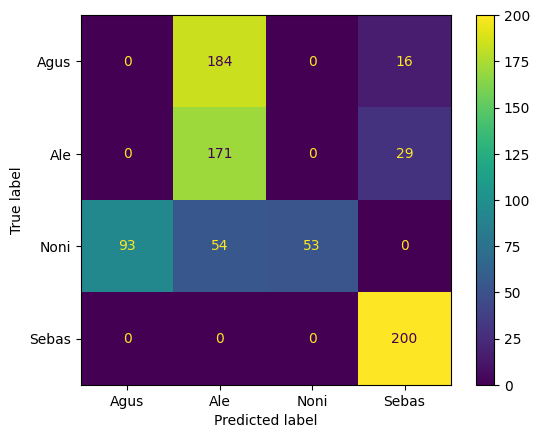



Modelo 5:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0
  Capa 2: 84 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5837
Recall: 0.7012

Graficando historial de entrenamiento...


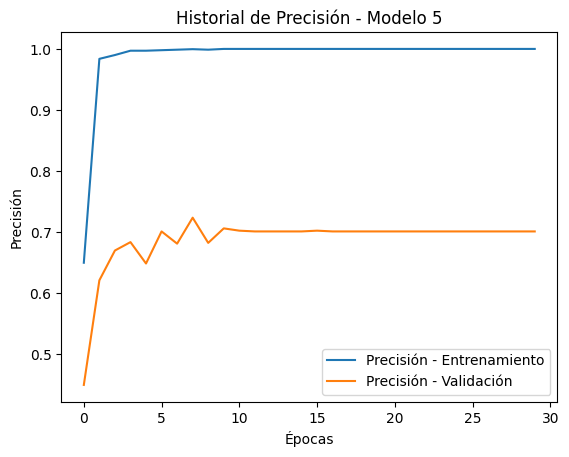

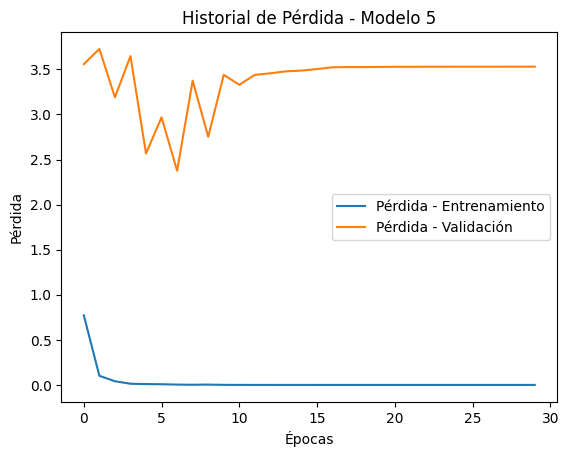


Matriz de Confusión:


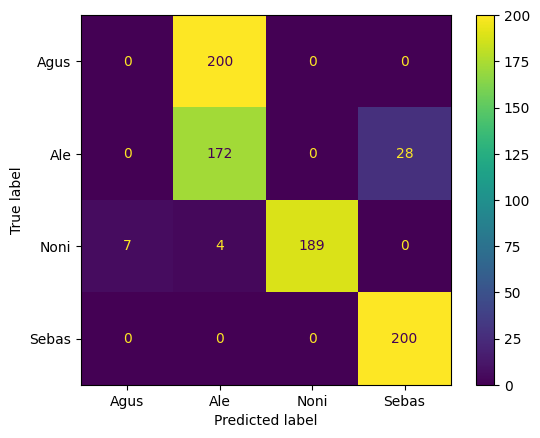



Modelo 6:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0
  Capa 2: 84 neuronas, activación='prelu', dropout=0
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5595
Recall: 0.4812

Graficando historial de entrenamiento...


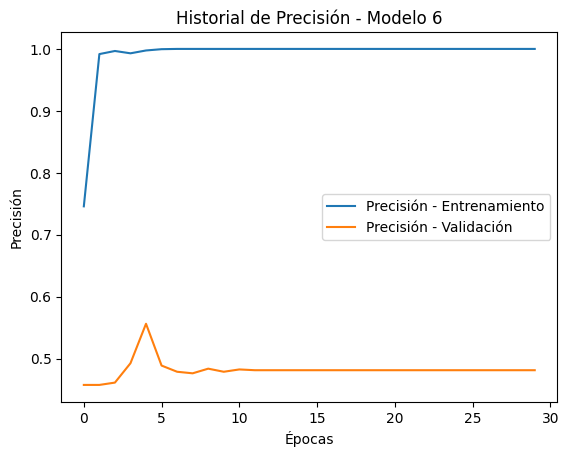

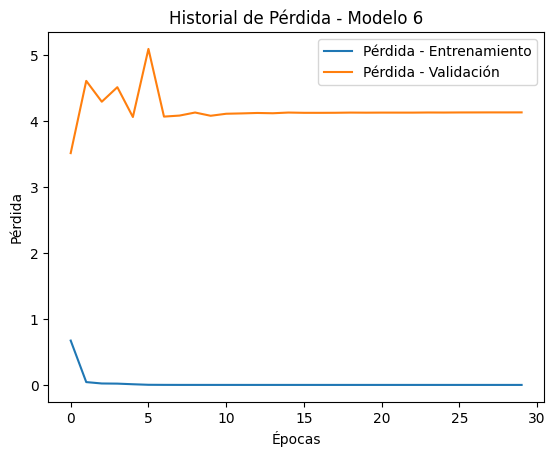


Matriz de Confusión:


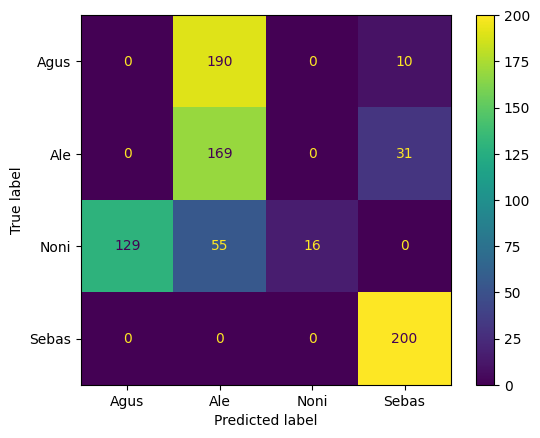



Modelo 7:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0.2
  Capa 2: 84 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5461
Recall: 0.5625

Graficando historial de entrenamiento...


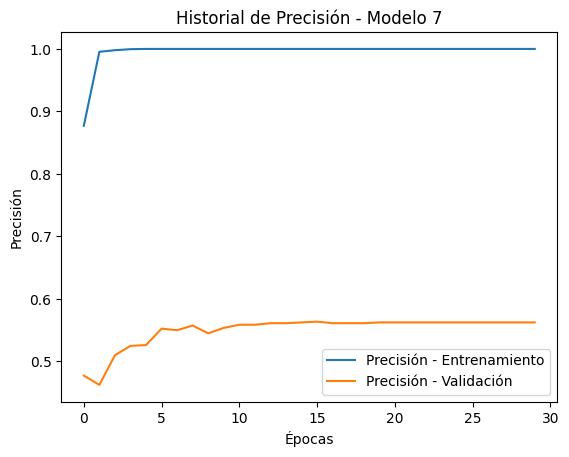

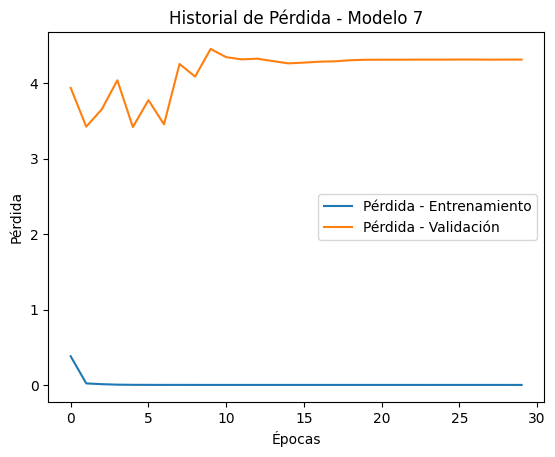


Matriz de Confusión:


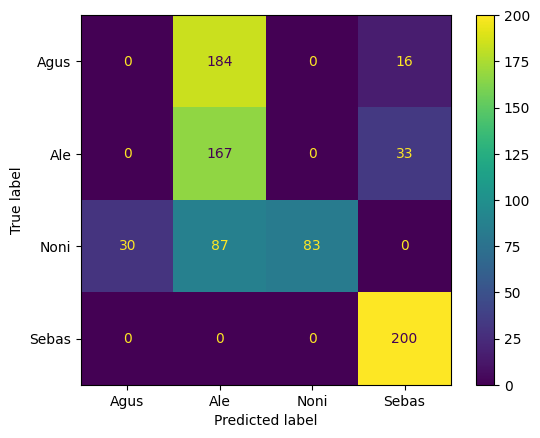



Modelo 8:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='tanh', dropout=0.2
  Capa 2: 84 neuronas, activación='tanh', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5530
Recall: 0.4650

Graficando historial de entrenamiento...


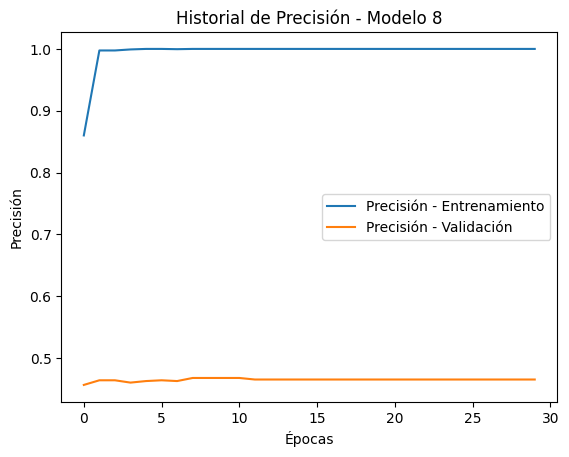

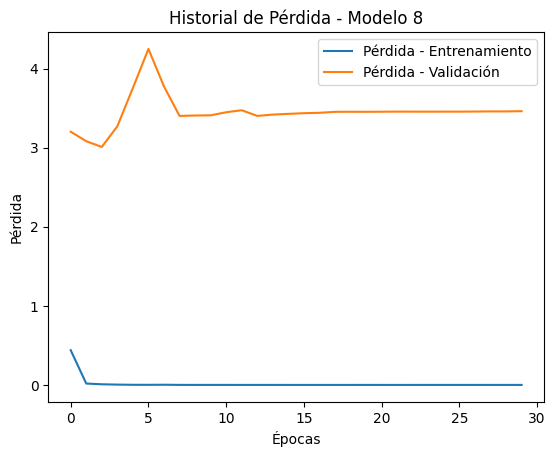


Matriz de Confusión:


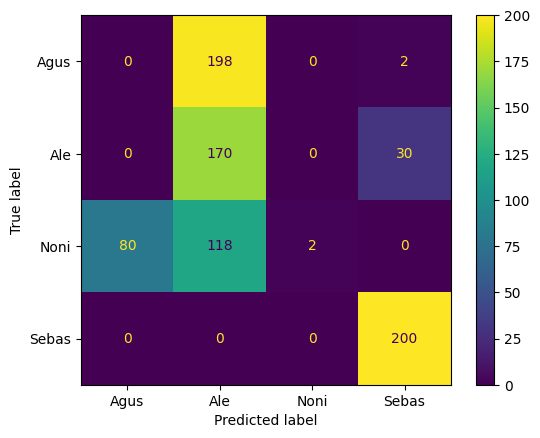



Modelo 9:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0.2
  Capa 2: 84 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5826
Recall: 0.7100

Graficando historial de entrenamiento...


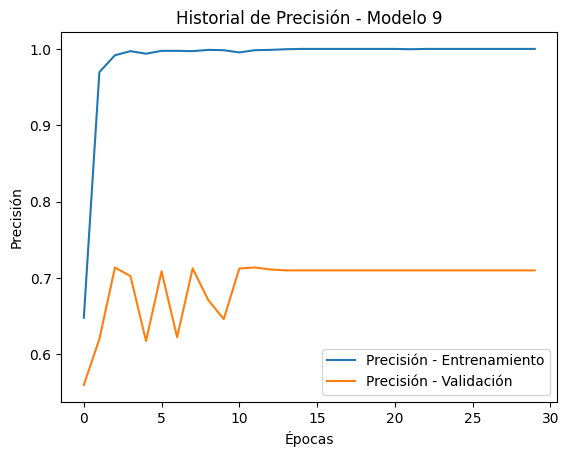

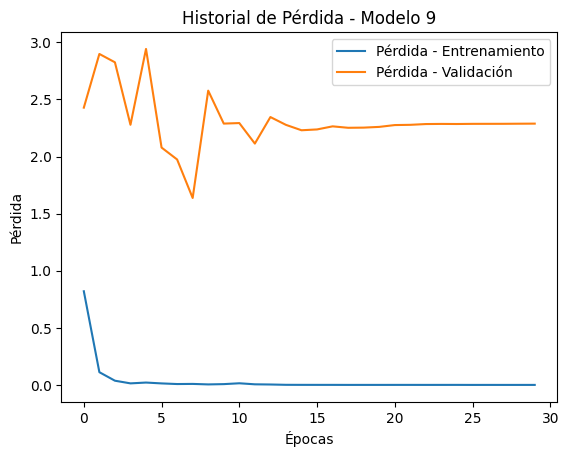


Matriz de Confusión:


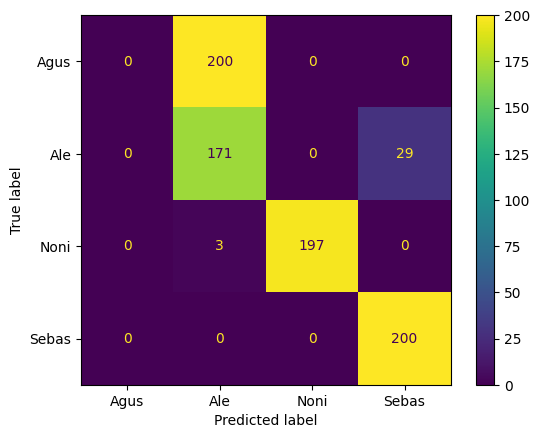



Modelo 10:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='relu', dropout=0.2
  Capa 2: 84 neuronas, activación='relu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5636
Recall: 0.4838

Graficando historial de entrenamiento...


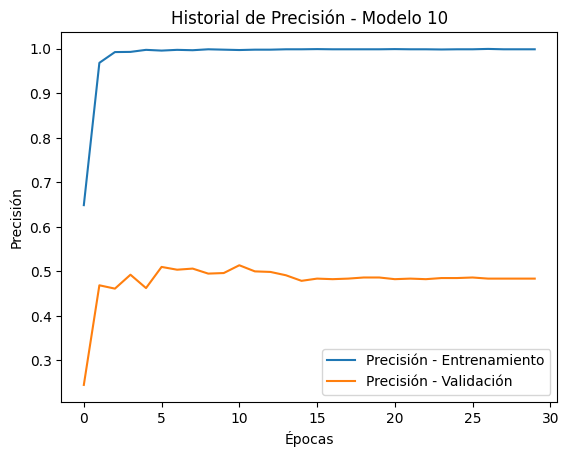

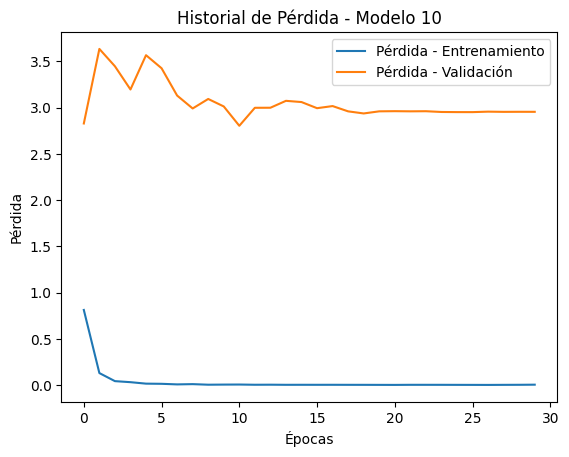


Matriz de Confusión:


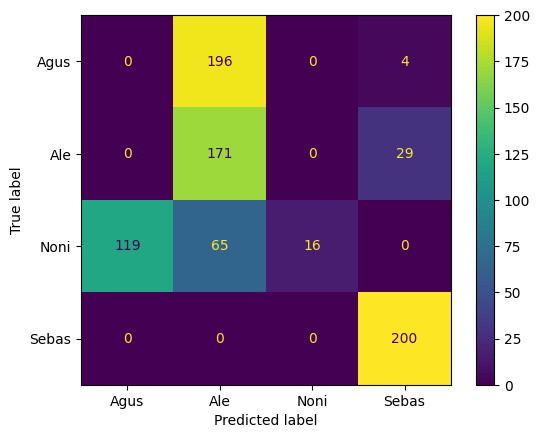



Modelo 11:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0.2
  Capa 2: 84 neuronas, activación='prelu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5631
Recall: 0.5188

Graficando historial de entrenamiento...


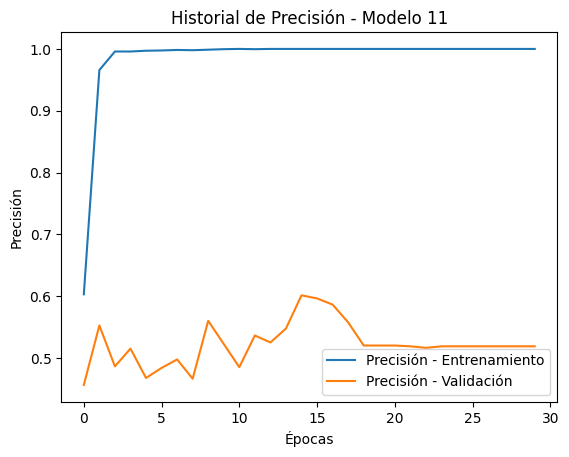

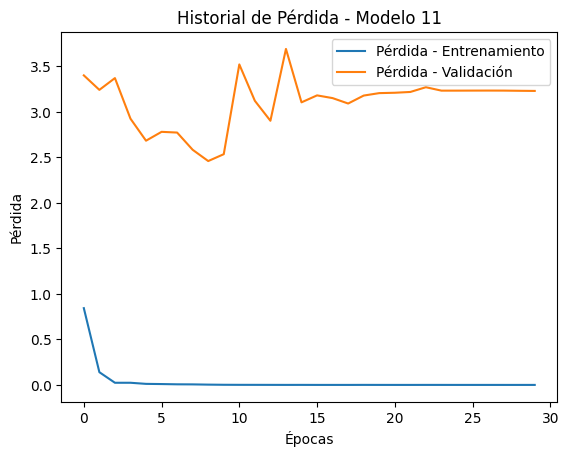


Matriz de Confusión:


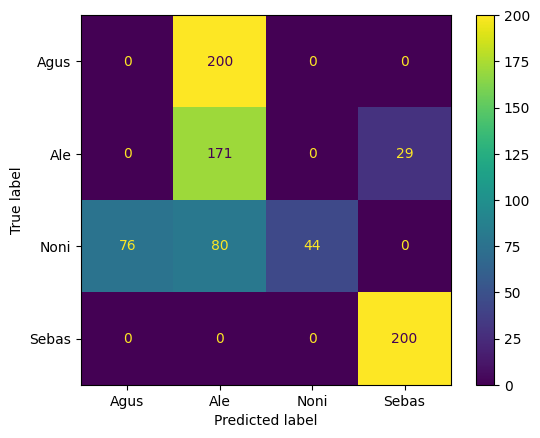



Modelo 12:
----------------------------------------
Configuración del modelo:
Capas Ocultas:
  Capa 1: 120 neuronas, activación='prelu', dropout=0.2
  Capa 2: 84 neuronas, activación='prelu', dropout=0.2
Learning Rate: 0.001
Factor de Reducción: 0.1
Salida: 4 neuronas, activación='softmax'

Métricas del modelo:
Precisión: 0.5801
Recall: 0.4750

Graficando historial de entrenamiento...


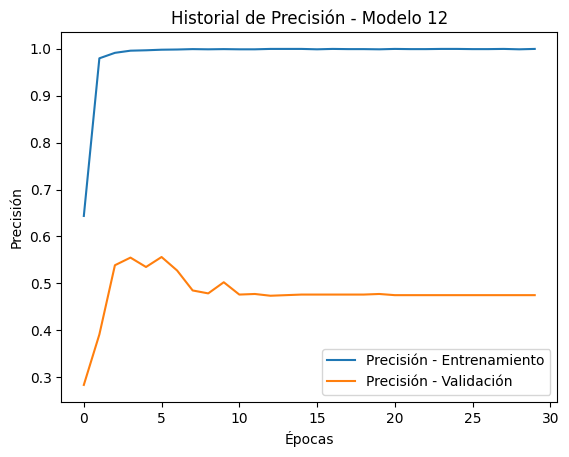

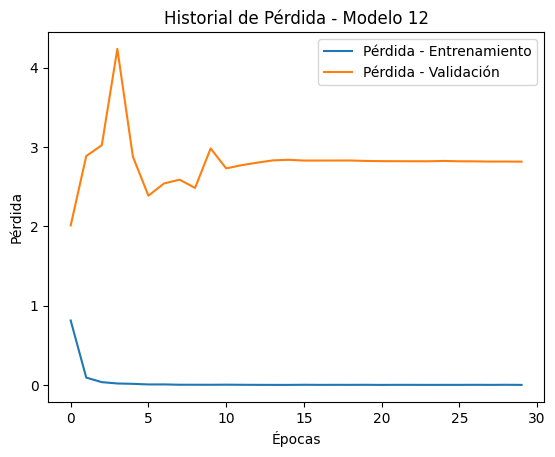


Matriz de Confusión:


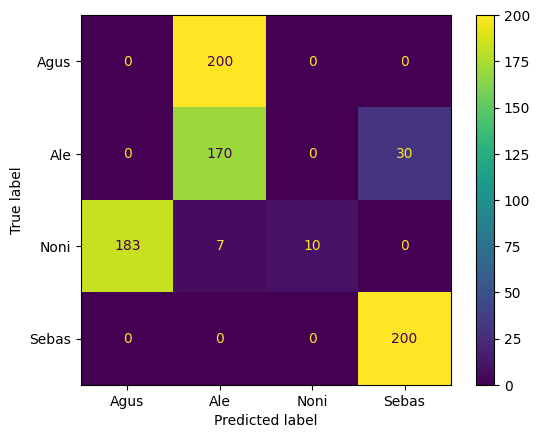

In [27]:
def mostrar_configuracion(configuracion):
    salida = []
    salida.append("Capas Ocultas:")
    for i, capa in enumerate(configuracion["capas_ocultas"]):
        salida.append(f"  Capa {i + 1}: {capa['neuronas']} neuronas, activación='{capa['activation']}', dropout={capa.get('dropout', 0)}")
    salida.append(f"Learning Rate: {configuracion['learning_rate']}")
    salida.append(f"Factor de Reducción: {configuracion['factor_reduccion']}")
    salida.append(f"Salida: {configuracion['output']['neuronas']} neuronas, activación='{configuracion['output']['activation']}'")
    return "\n".join(salida)

def mostrar_todo_dataframe(df, labels):
    for index, fila in df.iterrows():
        print(f"Modelo {index + 1}:")
        print("-" * 40)
        
        print("Configuración del modelo:")
        print(mostrar_configuracion(fila["configuracion"]))
        
        print("\nMétricas del modelo:")
        print(f"Precisión: {fila['precision']:.4f}")
        print(f"Recall: {fila['recall']:.4f}")
        
        historial = fila["historial"]
        print("\nGraficando historial de entrenamiento...")
        plt.plot(historial["accuracy"], label="Precisión - Entrenamiento")
        plt.plot(historial["val_accuracy"], label="Precisión - Validación")
        plt.title(f"Historial de Precisión - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Precisión")
        plt.legend()
        plt.show()

        plt.plot(historial["loss"], label="Pérdida - Entrenamiento")
        plt.plot(historial["val_loss"], label="Pérdida - Validación")
        plt.title(f"Historial de Pérdida - Modelo {index + 1}")
        plt.xlabel("Épocas")
        plt.ylabel("Pérdida")
        plt.legend()
        plt.show()

        print("\nMatriz de Confusión:")
        cm_display = ConfusionMatrixDisplay(fila["matriz_confusion"], display_labels=labels)
        cm_display.plot()
        plt.show()

        print("\n" + "=" * 50 + "\n")

mostrar_todo_dataframe(df_resultados, labels=labels)
